In [1]:
!pwd

/home/roman/deigo/H2/GRID_withFD


In [ ]:
# changed line 201 in grid_cell.py
# now, recording can only start if modularity is above 0.1
# in the GRID_withFD, this is 0.25 (so, for fairness, you need to re-run that sim (GRID_withFD))

In [ ]:
# check the log for any errors:

slurm_location = '/home/roman/deigo/H2/GRID_withFD/slurm_big/'
fnames = os.listdir(slurm_location)
tt = tqdm(fnames)
for i, fn in enumerate(tt):
    with open(slurm_location + fn, 'r') as f:
        tt.set_description(f"File name: {fn}")
        tt.refresh() # to show immediately the update
        lines = f.readlines()
        for line in lines:
            if 'error' in line:
                if not 'DUE TO TIME LIMIT' in line:
                    print(i, fn, 'error')
                    break
            if 'Error' in line:
                print(i, fn, 'Error')
                break 
            if 'Exception' in line:
                print(i, fn, 'Exception')
                break
            if 'exception' in line:
                print(i, fn, 'exception')
                break
#             if 'savi' in line:
#                 print(i, fn, 'savi')
#                 break
        

In [32]:
with open ('/home/roman/deigo/H2/GRID_withFD/slurm_big/11568288.out', 'r') as f:
    lines = f.readlines()
lines[-20:]

In [3]:
import os, pickle, sys, time
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import seaborn as sns; sns.set_theme()
import warnings
from tqdm import tqdm, trange
from pprint import pprint
from tqdm import tqdm
from scipy.stats import pearsonr
import threading
from termcolor import cprint
from multiprocessing import Pool
import scipy
from numba import njit, jit, prange




import networkx as nx
from sklearn.cluster import SpectralClustering
from scipy.sparse import csgraph

from sknetwork.clustering import Louvain, modularity
from sknetwork.linalg import normalize
from sknetwork.utils import bipartite2undirected, membership_matrix


def clusterize(w):
    x = np.copy(w[:2500, :2500])
    G = nx.from_numpy_matrix(x)
    adj_mat = nx.to_numpy_array(G)
    louvain = Louvain()
    labels = louvain.fit_transform(adj_mat)
    mod = modularity(adj_mat, labels)

    labels_unique, counts = np.unique(labels, return_counts=True)

    tmp = sorted([(i, d) for i, d in enumerate(labels)], key=lambda tup:tup[1], reverse=True)
    newids = [i[0] for i in tmp]

    W_ = x
    W_ = W_[newids, :]
    W_ = W_[:, newids]
    return W_, labels, counts, mod, newids

def find_t_where_var_is_zero(tmp):
    tmp_np = tmp[tmp.Std_nclust.notna()].Std_nclust.to_numpy().round(4)
    tmp_np_t = tmp[tmp.Std_nclust.notna()].t.to_numpy()
#     tmp[tmp.Std_nclust.notna()].plot(x='t', y='Std_nclust')
    x = np.argmax(tmp_np[::-1] > 0)
    where_std_zero = tmp_np.shape[0] - x
#     plt.axvline(tmp_np_t[where_std_zero])
    return tmp_np_t[where_std_zero]

def fetch_wt_snap_fnames(cell_id):
    path_to_weights = '/home/roman/bucket/slurm_big/'
    fnames = [i for i in os.listdir(path_to_weights) if i.endswith(f'.png')]
    sel_fnames = [i for i in fnames if int(i.split('_')[0]) == cell_id]
    tups = [(int(i.split('_')[1]), i) for i in sel_fnames]
    return sorted(tups, key=lambda tup: tup[0], reverse=False)[-1]

def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def delimit_upstates(tmp, FR_min, window, mingap, standard_gap):
    """
    PARAMETERS:
    
    tmp - dataframe of spikes in ONE cell assembly
    FR_min - threshold, below which we consider there to be a downstate
    window - interval, ms, in which we count spikes for FR
    mingap - minimum length of downstate that you want to delete
    standard_gap - the length of gap you want to truncate gaps larger than mingap (must be smaller than mingap)
    
    RETURNS
    ss - dataframe of upstate boundaries
    df_ - original spikes with a column that marks which spikes are not part of an upstate
    us_nogap - original dataframe with downstates dropped """

    @jit(fastmath=True, nopython=True, parallel=True, nogil=True)
    def fast_(spts, x, window):
        ma1 = np.zeros_like(spts)
        for i in prange(len(spts)):
            ma1[i] = np.sum((x >= (spts[i]- window/2)) & (x < (spts[i]+window/2)))
        return ma1
    
    df_ = tmp.copy()
    spts = df_.spiketime.to_numpy()
    x = df_.spiketime.to_numpy()
    t = time.time()

    ma1 = fast_(spts, x, window)
    df_['drop'] = ma1 < FR_min                    # mark down-states for dropping
    print(f'{(time.time()-t):2f} s.')

    # get upstate start and end times in a dataframe:
    ss_ = []
    seqstart = False
    for i, fr in enumerate(ma1):
        if fr > FR_min and not seqstart:
            start = spts[i]
            seqstart = True
        if fr <= FR_min and seqstart:
            seqstart = False
            stop = spts[i]
            ss_.append((start, stop, stop-start))
    ss = pd.DataFrame(ss_, columns=['start', 'stop', 'leng'])
    
    
    # drop the downstates:
    upstates = df_[df_['drop'] == False]
    x = upstates.spiketime.diff().values
    y = [i if i>mingap else 0 for i in x]
    y_ = [i-standard_gap if i>mingap else i for i in y]

    # new dataframe of spikes without downstates
    us_nogap = upstates.copy()
    us_nogap.reset_index(drop=True, inplace=True)
    us_nogap.spiketime -= np.cumsum(y_)
    us_nogap.spiketime -= us_nogap.spiketime.min()
    
    return ss, df_, us_nogap

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))


                           _ii:  4.6 KiB
                           _i1:  4.6 KiB
                           _i3:  4.6 KiB
                          tqdm:  1.0 KiB
                        prange:  1.0 KiB
            SpectralClustering:  1.0 KiB
                       Louvain:  1.0 KiB
                           _oh:  248.0 B
                           Out:  248.0 B
                        trange:  144.0 B


In [5]:
gr = pd.read_pickle('/home/roman/deigo/H2/GRID_withFD/df.pkl')
gr

,U,Cp,Cd,tpp,tpd,taustf,taustd
0,0.7708,0.1062,0.011,15.1549,120.4221,235.0004,100.0
1,0.8000,0.0200,0.005,15.1549,120.4221,50.0000,50.0
2,0.8000,0.0200,0.005,15.1549,120.4221,50.0000,100.0
3,0.8000,0.0200,0.005,15.1549,120.4221,50.0000,150.0
4,0.8000,0.0200,0.005,15.1549,120.4221,50.0000,200.0
...,...,...,...,...,...,...,...
9996,0.8000,0.2000,0.050,15.1549,120.4221,500.0000,300.0
9997,0.8000,0.2000,0.050,15.1549,120.4221,500.0000,350.0
9998,0.8000,0.2000,0.050,15.1549,120.4221,500.0000,400.0
9999,0.8000,0.2000,0.050,15.1549,120.4221,500.0000,450.0


In [2]:
def par():
    A = []
    fnames = [f for f in os.listdir('slurm_big/') if f.endswith('.out')]
    for fname in tqdm(fnames):
        with open(f'slurm_big/{fname}') as f:
            if 'DUE TO TIME LIMIT' in f.read():
                A.append(1)
    print(len(A))
                

threading.Thread(target=par).start()

  7%|▋         | 714/10001 [00:26<17:33,  8.81it/s]  

In [13]:
# build the grid

In [14]:
# A = []
# U = 0.8
# tpp, tpd = 15.1549, 120.4221
# grid_density = 10
# # for tpp in np.linspace(5, 25, grid_density):
# #     for tpd in np.linspace(100, 400, grid_density):
# # for U in np.linspace(0.5, 0.8, 1grid_density5):
# for Cp in np.linspace(0.02, 0.20, grid_density):
#     for Cd in np.linspace(0.005, 0.05, grid_density):
#         for taustf in np.linspace(50, 500, grid_density):
#             for taustd in np.linspace(50, 500, grid_density):
#                 A.append({'U':U, 'Cp':Cp, 'Cd':Cd, 'tpp':tpp, 'tpd':tpd, 'taustf':taustf, 'taustd':taustd})

In [15]:
# A.insert(0, {'U':0.7708, 
#              'Cp':0.1062, 
#              'Cd':0.0110, 
#              'tpp':15.1549, 
#              'tpd':120.4221,
#              'taustf':235.0004,
#              'taustd':100.0000})
# pd.DataFrame(A).to_pickle('df.pkl')
# gr = pd.read_pickle('df.pkl')

# gr

In [2]:
!pwd

/home/roman/deigo/H2/GRID_withFD


In [4]:
!split -l 2000000  mod_big.txt # split the big data into smaller pieces, so Pandas can handle them one by one
with open('mod_big.txt', 'r') as f:
    lines = f.readlines()

In [5]:
c = 0
for line in lines:
    if len(line.split(', ')) > 8:
        c += 1
print(f'Total lines: {len(lines)}, Bad lines: {c}')
print(f"Files in slurm_big: {len(os.listdir('./slurm_big'))}")

Total lines: 3390135, Bad lines: 1519
Files in slurm_big: 2000


In [46]:
# ! rm -r slurm
# ! mkdir slurm

In [6]:
# READ RAW DATA OR LOAD IT (CELL BELOW)

def fix_bad_lines_in_data(fname):
    c = 0
    with open(fname, 'r') as f:
        lines = f.readlines()
    with open(f"{fname}_fixed", "w") as f:   
        for line in lines:
            if len(line.split(', ')) == 8:
                f.write(line)
            else:
                 c += 1
    print(f'Total lines: {len(lines)}, Bad lines: {c}')
    
df = pd.DataFrame()
for i in [i for i in os.listdir() if i.startswith('xa')]:
    try:
        df = df.append(pd.read_csv(i, header=None, error_bad_lines=False, warn_bad_lines=False))
    except:
        print(f'Error in {i}. Fixing...')
        fix_bad_lines_in_data(i)
        df = df.append(pd.read_csv(f'{i}_fixed', header=None, error_bad_lines=False, warn_bad_lines=False))
        
df.reset_index(drop=True, inplace=True)


gr = pd.read_pickle('df.pkl')
df.columns = ['JOB_ID', 'TASK_ID', 'cell_id', 't', 'mod', 'n_clust', 'min_clust', 'max_clust']
for j, i in tqdm(enumerate(gr.columns)):
    df[i] = df.dropna().cell_id.apply(lambda x: gr.loc[int(x), i])
df['Cp'] = df.apply(lambda x: np.round(x.Cp, 3), axis=1)
df['Cd'] = df.apply(lambda x: np.round(x.Cd, 3), axis=1)

df.to_pickle('dfFrom_make_grid-BIG.pickle')

df

7it [02:36, 22.36s/it]


,JOB_ID,TASK_ID,cell_id,t,mod,n_clust,min_clust,max_clust,U,Cp,Cd,tpp,tpd,taustf,taustd
0,11531125.0,1.0,1.0,0.0,0.021292,12.0,2.0,388.0,0.8000,0.020,0.005,15.1549,120.4221,50.0000,50.0
1,11531124.0,1.0,0.0,0.0,0.021832,9.0,34.0,445.0,0.7708,0.106,0.011,15.1549,120.4221,235.0004,100.0
2,11531128.0,1.0,3.0,0.0,0.020872,13.0,1.0,412.0,0.8000,0.020,0.005,15.1549,120.4221,50.0000,150.0
3,11531129.0,1.0,4.0,0.0,0.021814,9.0,102.0,379.0,0.8000,0.020,0.005,15.1549,120.4221,50.0000,200.0
4,11531126.0,1.0,2.0,0.0,0.021195,10.0,9.0,439.0,0.8000,0.020,0.005,15.1549,120.4221,50.0000,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3363462,11532300.0,1.0,773.0,9725000.0,0.023293,14.0,2.0,409.0,0.8000,0.020,0.040,15.1549,120.4221,400.0000,150.0
3363463,11533916.0,1.0,1717.0,8945000.0,0.023549,11.0,6.0,433.0,0.8000,0.040,0.040,15.1549,120.4221,100.0000,350.0
3363464,11532899.0,1.0,1326.0,8395000.0,0.021222,12.0,2.0,370.0,0.8000,0.040,0.020,15.1549,120.4221,150.0000,300.0
3363465,11531485.0,1.0,290.0,8325000.0,0.020406,10.0,7.0,362.0,0.8000,0.020,0.015,15.1549,120.4221,450.0000,500.0


In [48]:
# or just load good data:
df = pd.read_pickle('dfFrom_make_grid-BIG.pickle')

In [14]:
leaders = df[df['mod'] >= 0.1].cell_id.unique().tolist()
print(f'N leaders: {len(leaders)}')

N leaders: 8


In [11]:
df[df.cell_id == leaders[10]].sort_values(by='t')

IndexError: list index out of range

In [15]:
leaders

[0.0, 1071.0, 1091.0, 1061.0, 1081.0, 1051.0, 1092.0, 1041.0]

100%|██████████| 2/2 [00:00<00:00, 41.08it/s]


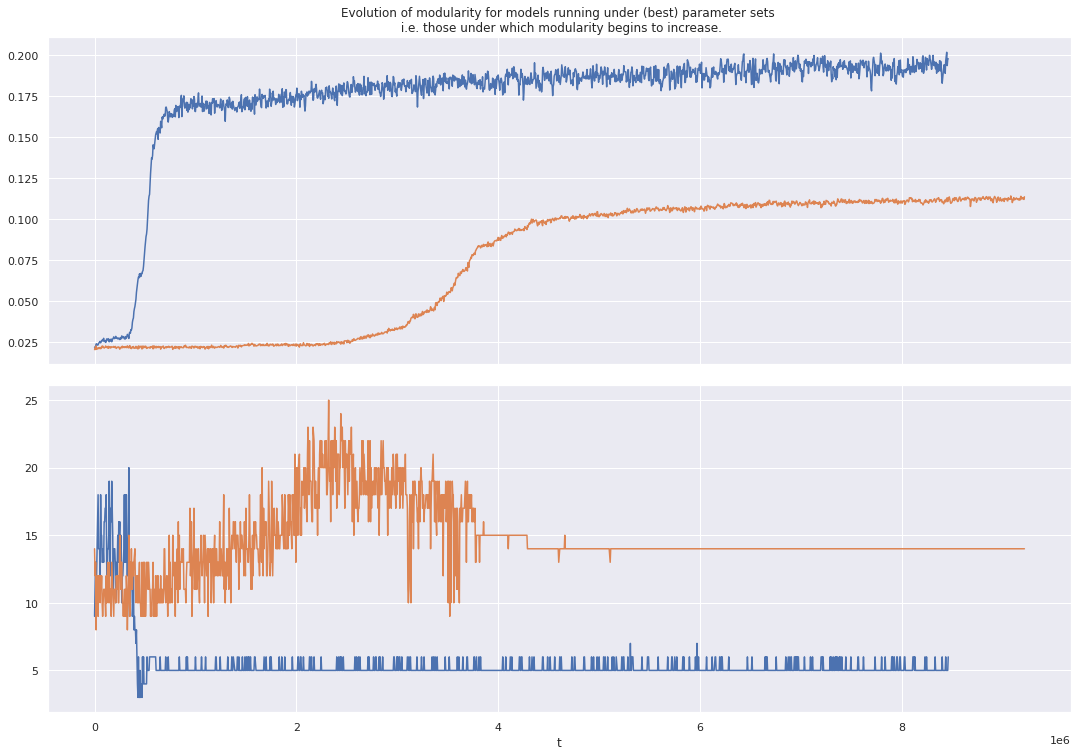

In [18]:
%matplotlib inline

fig, ax = plt.subplots(2,1, figsize=(15,10), sharex=True)
plt.tight_layout()

for j, i in enumerate(tqdm(leaders[:2])):
# for j, i in enumerate(tqdm(lst)):
    df[df.cell_id == i].sort_values(by='t').plot(x='t', y='mod', label=i, ax=ax[0], legend=None)
    df[df.cell_id == i].sort_values(by='t').plot(x='t', y='n_clust', label=i, ax=ax[1], legend=None)
ax[0].set_title('Evolution of modularity for models running under (best) parameter sets \n i.e. those under which modularity begins to increase.')
# ax[0].axvline(430000)
plt.savefig('mod_big_.pdf')

<AxesSubplot:xlabel='t'>

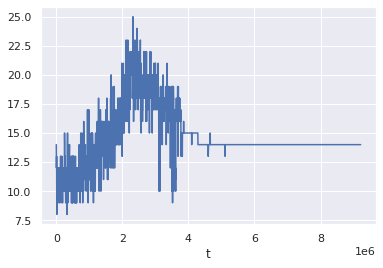

In [20]:
df[df.cell_id == 1071].sort_values(by='t').plot(x='t', y='n_clust', label=i, legend=None)

In [22]:
df[df.cell_id == 1071]

,JOB_ID,TASK_ID,cell_id,t,mod,n_clust,min_clust,max_clust,U,Cp,Cd,tpp,tpd,taustf,taustd
53939,11532623.0,1.0,1071.0,0.0,0.020393,14.0,11.0,425.0,0.8,0.04,0.005,15.1549,120.4221,400.0,50.0
54890,11532623.0,1.0,1071.0,5000.0,0.021413,12.0,1.0,399.0,0.8,0.04,0.005,15.1549,120.4221,400.0,50.0
55858,11532623.0,1.0,1071.0,10000.0,0.020433,13.0,1.0,388.0,0.8,0.04,0.005,15.1549,120.4221,400.0,50.0
56826,11532623.0,1.0,1071.0,15000.0,0.022595,8.0,28.0,418.0,0.8,0.04,0.005,15.1549,120.4221,400.0,50.0
57795,11532623.0,1.0,1071.0,20000.0,0.020618,11.0,91.0,335.0,0.8,0.04,0.005,15.1549,120.4221,400.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3356233,11532623.0,1.0,1071.0,9195000.0,0.112424,14.0,140.0,217.0,0.8,0.04,0.005,15.1549,120.4221,400.0,50.0
3358009,11532623.0,1.0,1071.0,9200000.0,0.112992,14.0,139.0,206.0,0.8,0.04,0.005,15.1549,120.4221,400.0,50.0
3359753,11532623.0,1.0,1071.0,9205000.0,0.113172,14.0,140.0,210.0,0.8,0.04,0.005,15.1549,120.4221,400.0,50.0
3361499,11532623.0,1.0,1071.0,9210000.0,0.112055,14.0,132.0,213.0,0.8,0.04,0.005,15.1549,120.4221,400.0,50.0


0it [00:00, ?it/s]


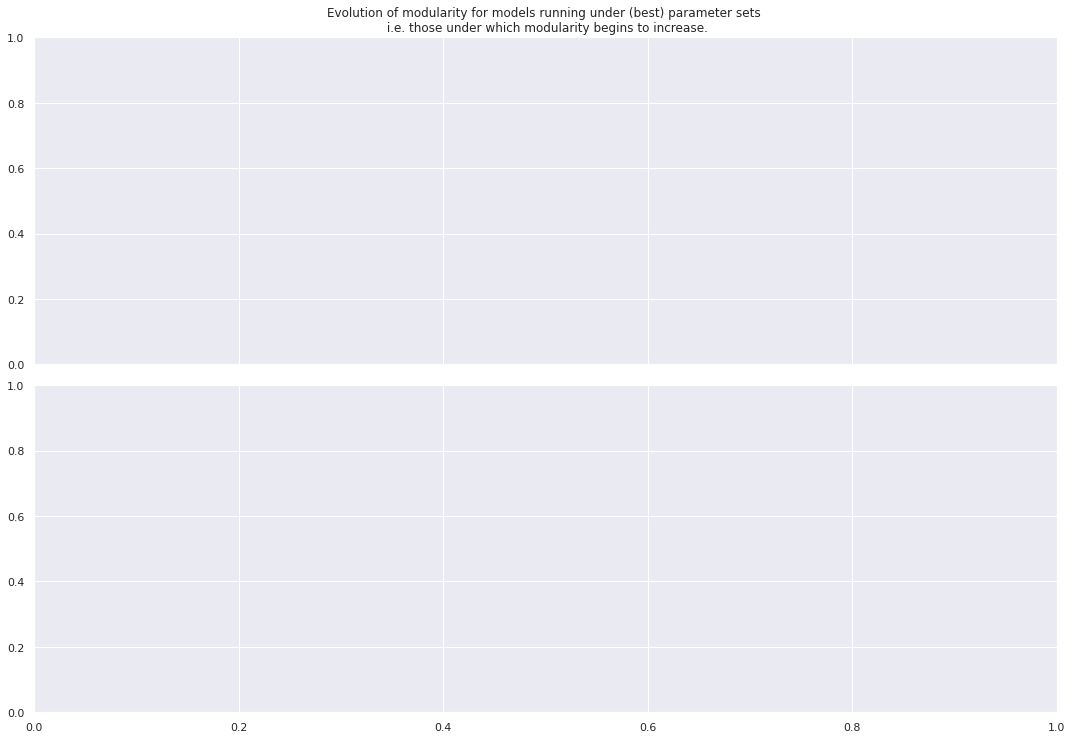

In [13]:
%matplotlib inline

fig, ax = plt.subplots(2,1, figsize=(15,10), sharex=True)
plt.tight_layout()

leaders = [int(f[:4]) for f in os.listdir('/home/roman/bucket/slurm_big_HAGAwithFD/') if f.endswith('.png')]
for j, i in enumerate(tqdm(leaders)):
# for j, i in enumerate(tqdm(lst)):
    df[df.cell_id == i].sort_values(by='t').plot(x='t', y='mod', label=i, ax=ax[0], legend=None)
    df[df.cell_id == i].sort_values(by='t').plot(x='t', y='n_clust', label=i, ax=ax[1], legend=None)
ax[0].set_title('Evolution of modularity for models running under (best) parameter sets \n i.e. those under which modularity begins to increase.')
# ax[0].axvline(430000)
plt.savefig('mod_big_.pdf')

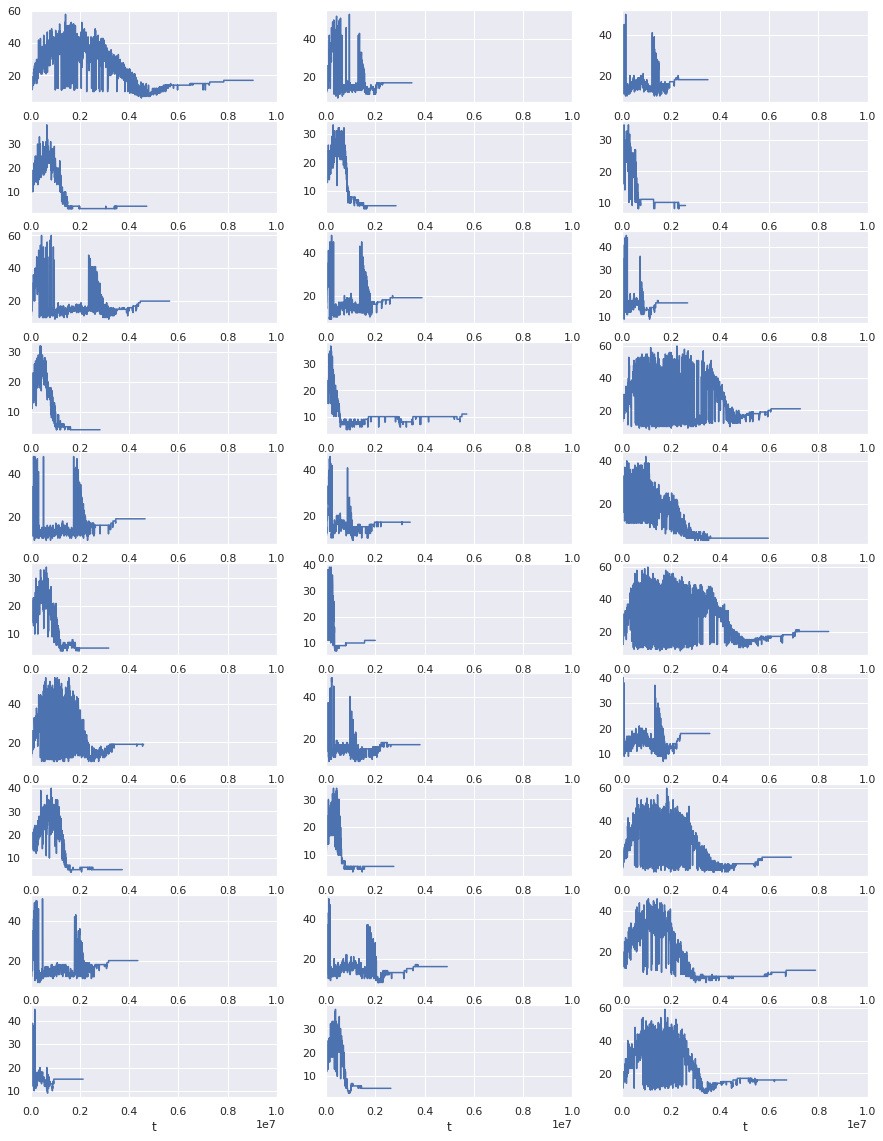

In [82]:
plt.figure(figsize=(15,20))
for i in range(30):
    plt.subplot(10,3,i+1)
    df[df.cell_id == leaders[i]].sort_values(by='t').plot(x='t', y='n_clust', label=i, ax=plt.gca(), legend=None)
    plt.xlim(0, 10e6)

<AxesSubplot:xlabel='spiketime'>

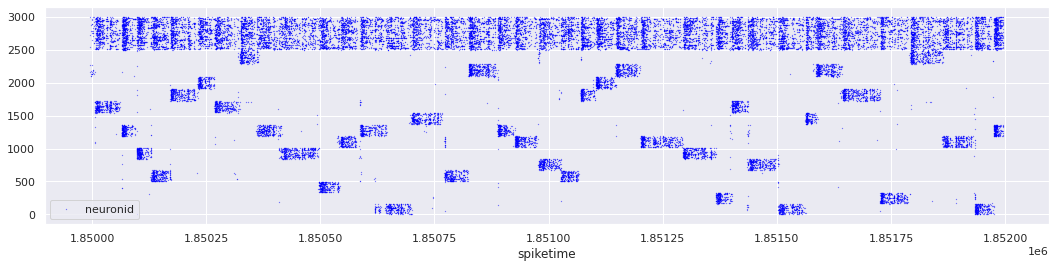

In [2]:
cell_id = 3383

spts = pd.read_csv(f'/home/roman/bucket/slurm_big_HAGAwoFD/spike_times_{cell_id}', sep=' ', header=None)
spts.columns = ['spiketime', 'neuronid']
st = spts.spiketime.min()
en = spts.spiketime.min() + 2000

with open(f'/home/roman/bucket/slurm_big_HAGAwoFD/wts_org_{cell_id}.pkl', 'rb') as f:
    w = pickle.load(f)[:2500, :2500]
w_, labels, counts, mod, newids = clusterize(w)
sub_sorted = spts.copy()
sub_sorted['neuronid'] =  spts.neuronid.map({j:i for i,j in enumerate(newids)}).fillna(spts.neuronid).astype('int')



fig, ax = plt.subplots(1,1, figsize=(18,4))
sub_sorted[(sub_sorted.spiketime >= st) & (sub_sorted.spiketime < en)].plot(x='spiketime', y='neuronid', style='o', color='blue', ms=0.2, ax=ax)



In [3]:
from scipy.sparse import csr_matrix

In [71]:
Spts = csr_matrix((3000, 600000), dtype=np.bool).tolil()

spts_ = spts.to_numpy()
spts_[:,0] -= spts_[:,0].min()

for i in trange(spts_.shape[0]):
    spt = int(spts_[i,0])
    nid = int(spts_[i,1])
    Spts[nid, spt] = 1     

100%|██████████| 9684782/9684782 [00:42<00:00, 225627.74it/s]


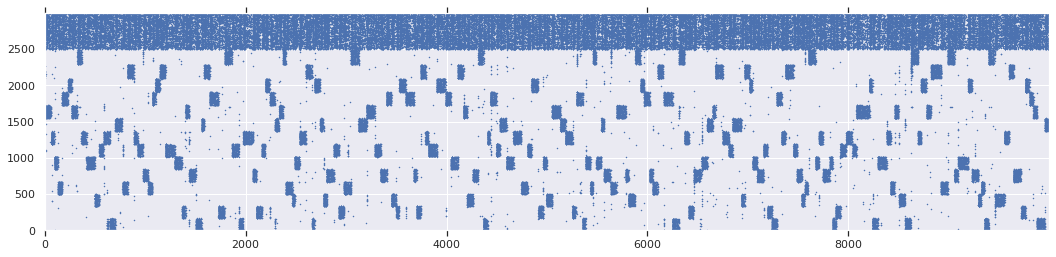

In [6]:
fig, ax = plt.subplots(1,1, figsize=(18,4))
ax.spy(Spts[newids + [i for i in range(2500, 3000)], :10000], aspect='auto', ms=0.5, origin='lower')

In [78]:
win = 10


def computeMI(i):
    global Spts, win
    MI_row = []
    spike_places_a = np.nonzero(Spts[:, i:i+win].toarray().flatten())[0]
    for j in np.arange(0,2000, int(win)):
        spike_places_b = np.nonzero(Spts[:, j:j+win].toarray().flatten())[0]
        enumerator = len(set(spike_places_a).intersection(spike_places_b))
        denominator = len(spike_places_a) + len(spike_places_b)
        mi = 2 * enumerator/denominator
        MI_row.append(mi)
    return MI_row
    
lst = np.arange(0,2000, int(win))
with Pool(25) as p:
    MI = list(tqdm(p.imap(computeMI, lst), total=len(lst))) # with a progress bar
MI = np.stack(MI)

100%|██████████| 200/200 [00:38<00:00,  5.22it/s]


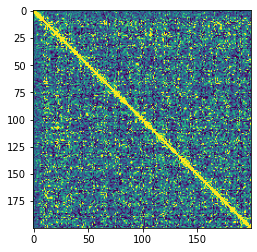

In [79]:
sns.reset_orig()
plt.imshow(MI, vmax=0.03)

In [72]:
# MI0 = np.copy(MI)

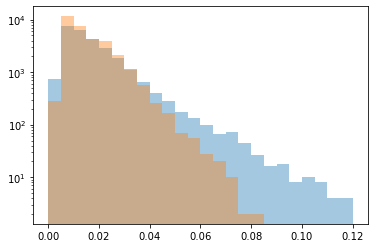

In [88]:
_ = plt.hist(MI0[(MI0<0.9) & (MI0>0)].flatten(), bins=np.linspace(0,0.12,25), alpha=0.4, density=False)
_ = plt.hist(MI[(MI<0.9) & (MI>0)].flatten(), bins=np.linspace(0,0.12,25), alpha=0.4, density=False)
plt.gca().set_yscale('log')

In [50]:
def permuteISIs(df): 
    df_ = df.sort_values(['neuronid', 'spiketime'])
    for n in trange(df.neuronid.max()+1):
        # get spts
        x = df_[df_.neuronid == n].spiketime.to_numpy()
        if x.shape[0] < 3:
            continue
        # from spts to ISIs
        d = np.diff(np.insert(x, 0, 0.0))
        np.random.shuffle(d)
        # from ISI back to spts
        x_ = np.cumsum(d)
        df_.loc[df_.neuronid == n, 'spiketime'] = x_
    return df_

tmp = spts.copy()
tmp['spiketime'] -= tmp['spiketime'].min()
tmp = permuteISIs(tmp)
# plt.plot(tmp.spiketime, tmp.neuronid, 'bo', ms=0.2)

100%|██████████| 3000/3000 [03:26<00:00, 14.53it/s]


<AxesSubplot:xlabel='spiketime'>

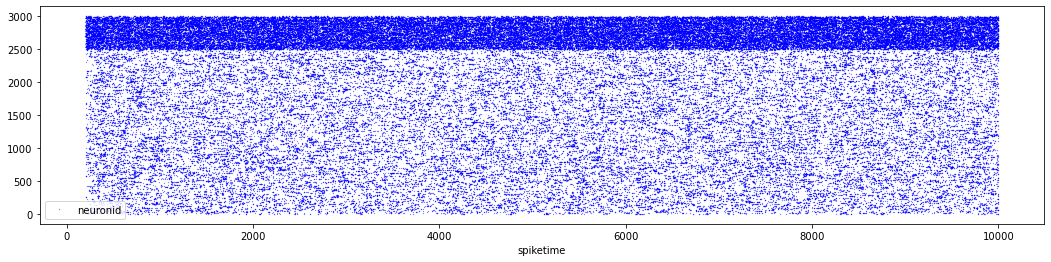

In [55]:
fig, ax = plt.subplots(1,1, figsize=(18,4))
tmp[(tmp.spiketime >= 200) & (tmp.spiketime < 10000)].plot(x='spiketime', y='neuronid', style='o', color='blue', ms=0.2, ax=ax)

In [53]:
en

1851996.332

In [49]:
# # select the ones that have stabilized (n_clust) and are among the leaders:

# tmp = df[df.cell_id.isin(leaders)].sort_values(by=['cell_id', 't'])
# stable_leaders = []
# for i in tqdm(tmp.cell_id.unique()):
#     std = tmp[tmp.cell_id == i].sort_values(by='t').n_clust.to_numpy()[-100:].std()
#     nc = tmp[tmp.cell_id == i].sort_values(by='t').n_clust.to_numpy()[-1]
#     if std == 0:
#         stable_leaders.append((nc, i))
# stable_leaders.sort(key=lambda tup: tup[0], reverse=True)
# stable_leaders = [int(i[1]) for i in stable_leaders]

# tmp.to_pickle('tmpFrom_make_grid-BIG.pickle')

100%|██████████| 5553/5553 [02:09<00:00, 42.90it/s]


In [10]:
# or just load from disk
tmp = pd.read_pickle('tmpFrom_make_grid-BIG.pickle')

stable_leaders = []
for i in tqdm(tmp.cell_id.unique()):
    std = tmp[tmp.cell_id == i].sort_values(by='t').n_clust.to_numpy()[-100:].std()
    nc = tmp[tmp.cell_id == i].sort_values(by='t').n_clust.to_numpy()[-1]
    if std == 0:
        stable_leaders.append((nc, i))
stable_leaders.sort(key=lambda tup: tup[0], reverse=True)
stable_leaders = [int(i[1]) for i in stable_leaders]

100%|██████████| 5553/5553 [02:14<00:00, 41.36it/s]


In [11]:
len(stable_leaders)

2292

In [17]:
stable_leaders[1001:1003]

[7402, 7413]

2it [00:00, 15.58it/s]


Text(0.5, 1.0, 'Evolution of modularity for models running under (best) parameter sets \n i.e. those under which modularity begins to increase.')

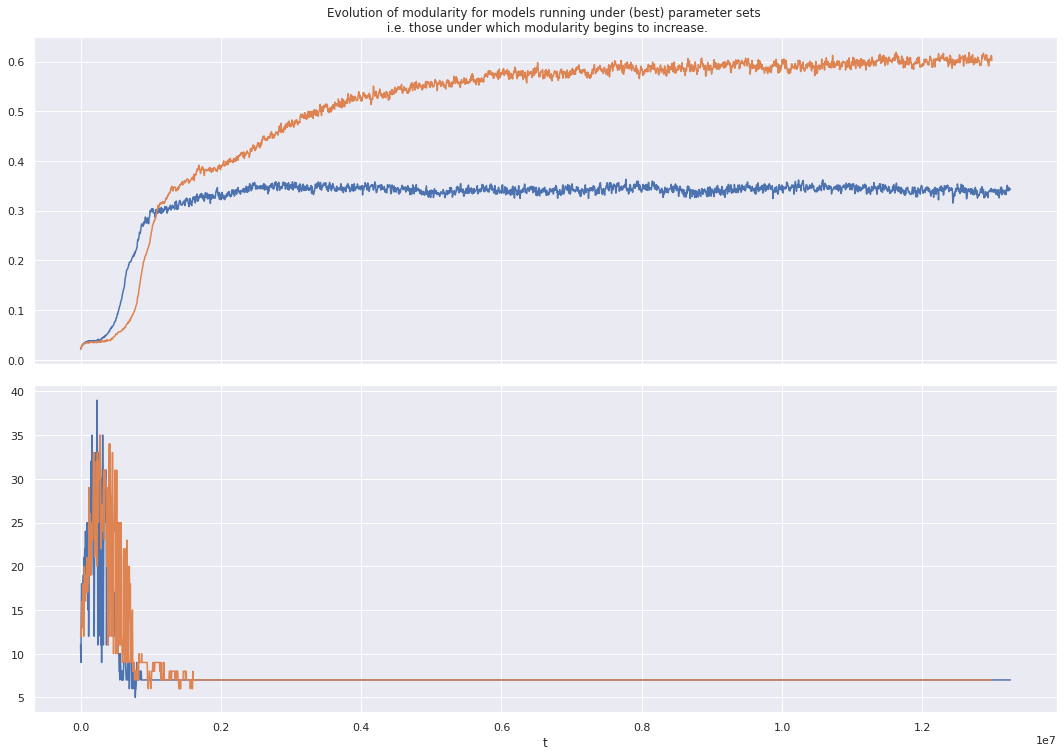

In [16]:
%matplotlib inline

fig, ax = plt.subplots(2,1, figsize=(15,10), sharex=True)
plt.tight_layout()

for j, i in tqdm(enumerate(stable_leaders[1001:1003])):
    df[df.cell_id == i].sort_values(by='t').plot(x='t', y='mod', label=i, ax=ax[0], legend=None)
    df[df.cell_id == i].sort_values(by='t').plot(x='t', y='n_clust', label=i, ax=ax[1], legend=None)
ax[0].set_title('Evolution of modularity for models running under (best) parameter sets \n i.e. those under which modularity begins to increase.')
# ax[0].axvline(430000)

In [9]:
# tmp['Std_nclust'] = np.nan
# tmp['Std_nclust'] = tmp[tmp.cell_id == i].sort_values(by='t').n_clust.rolling(10, win_type='boxcar').std()

In [10]:
# # Inspect triplets of __ stabilized leaders __ (SLOW !!!)
# # save pictures

# A = []
# tmp['Std_nclust'] = np.nan
# for j in trange(0, len(stable_leaders[:12]), 3): # from which stabilized leader to start
#     fit, ax = plt.subplots(nrows=3, ncols=3, figsize=(18,12))
#     plt.tight_layout()
#     k = 0
#     for i in stable_leaders[j:j+3]:
#         ax0 = ax[0,k]
#         ax1 = ax[0,k].twinx()

#         tmp[tmp.cell_id == i].plot(x='t', y='mod', ax=ax0, label=int(i), color='red')

#         ax0.set_xlim(0, 1.4e7)
#         ax0.set_ylim(-0.04, 0.8)
#         ax0.legend()


#         ax0.set_ylabel('modularity')
#         ax0.yaxis.label.set_color('red')
#         ax0.tick_params(axis='y', colors='red')
#         ax[1,k].set_ylim(0, 30)

#         tmp['Std_nclust'] = tmp[tmp.cell_id == i].sort_values(by='t').n_clust.rolling(10, win_type='boxcar').std()
#         tmp.plot(x='t', y='Std_nclust', ax=ax1, label=int(i), color='green')
#         t_zero = find_t_where_var_is_zero(tmp)
#         ax1.axvline(t_zero, lw=0.5, color='grey')
#         ax[1,k].axvline(t_zero, lw=0.5, color='grey')
#         ax[1,k].set_ylabel('Number of assemblies')

#         tmp[tmp.cell_id == i].plot(x='t', y='n_clust', ax=ax[1,k], label=f'cell_id: {int(i)}')
#         mod_ = tmp[(tmp.cell_id == i) & (tmp.t == t_zero)]['mod'].to_numpy()[0]
#         n_clust_ = tmp[(tmp.cell_id == i) & (tmp.t == t_zero)].n_clust.to_numpy()[0]
#         ax1.set_ylim(-1, 17)
#         ax1.grid(False)

#         ax1.set_ylabel('n_clust std')
#         ax1.yaxis.label.set_color('green')
#         ax1.tick_params(axis='y', colors='green')


#         if k !=0:
#             ax[0,k].yaxis.label.set_color('white')
#             ax[0,k].tick_params(axis='y', colors='white')
#         if k !=2:
#             ax1.yaxis.label.set_color('white')
#             ax1.tick_params(axis='y', colors='white')
#         ax[1,k].set_xlim(ax0.get_xlim())

#         latest_t, fname = fetch_wt_snap_fnames(i)
#         ax0.axvline(latest_t, color='red', linewidth=0.5)
#         img = mpimg.imread(f'/home/roman/bucket/slurm_big/{fname}')
        
#         ax[2,k].imshow((np.clip(img[100:1283, 428:1530]*2, 0, 1) * 255).astype('uint8'))
#         ax[2,k].xaxis.set_visible(False)
#         ax[2,k].yaxis.set_visible(False)
#         ax[2,k].set_title(f'{latest_t}\n{fname}')
#         ax[0,k].axes.get_xaxis().get_label().set_visible(False)
#         ax[1,k].axes.get_xaxis().get_label().set_visible(False)

#         k += 1
#         cl = df[(df.cell_id == i) & (df.t == t_zero)]
#         A.append({
#             'JOB_ID': cl.JOB_ID.values[0],
#             'mod':cl['mod'].values[0],
#             'mod_': mod_,
#             'n_clust':cl.n_clust.values[0],
#             'n_clust_': n_clust_,
#             'min_clust':cl.min_clust.values[0],
#             'max_clust':cl.max_clust.values[0],
#             'U':cl.U.values[0],
#             'Cp':cl.Cp.values[0],
#             'Cd':cl.Cd.values[0],
#             'tpp':cl.tpp.values[0],
#             'tpd':cl.tpd.values[0],
#             'taustf':cl.taustf.values[0],
#             'taustd':cl.taustd.values[0],
#             'cell_id': i,
#             't_': t_zero
#         })
#     with open('A.p', 'wb') as f:
#         pickle.dump(A, f)
#     _= plt.subplots_adjust(wspace=0.1, hspace=0.3, left=0.05, right=0.95)
#     _= plt.savefig(f'xjj_{j}.jpg', transparent=False)
#     _= plt.clf()
#     _= plt.close()

# dd = pd.DataFrame(A)

In [11]:
# SAME AS ABOVE, BUT WITHOUT SAVING PICTURES, HENCE FASTER
# Inspect triplets of __ stabilized leaders __
# save pictures

A = []
tmp['Std_nclust'] = np.nan
for j in trange(0, len(stable_leaders), 3): # from which stabilized leader to start
    k = 0
    for i in stable_leaders[j:j+3]:
        tmp['Std_nclust'] = tmp[tmp.cell_id == i].sort_values(by='t').n_clust.rolling(10, win_type='boxcar').std()
        t_zero = find_t_where_var_is_zero(tmp)
        mod_ = tmp[(tmp.cell_id == i) & (tmp.t == t_zero)]['mod'].to_numpy()[0]
        n_clust_ = tmp[(tmp.cell_id == i) & (tmp.t == t_zero)].n_clust.to_numpy()[0]
        k += 1
        cl = df[(df.cell_id == i) & (df.t == t_zero)]
        A.append({
            'JOB_ID': cl.JOB_ID.values[0],
            'mod':cl['mod'].values[0],
            'mod_': mod_,
            'n_clust':cl.n_clust.values[0],
            'n_clust_': n_clust_,
            'min_clust':cl.min_clust.values[0],
            'max_clust':cl.max_clust.values[0],
            'U':cl.U.values[0],
            'Cp':cl.Cp.values[0],
            'Cd':cl.Cd.values[0],
            'tpp':cl.tpp.values[0],
            'tpd':cl.tpd.values[0],
            'taustf':cl.taustf.values[0],
            'taustd':cl.taustd.values[0],
            'cell_id': i,
            't_': t_zero
        })
with open('A.p', 'wb') as f:
    pickle.dump(A, f)

dd = pd.DataFrame(A)

100%|██████████| 764/764 [16:00<00:00,  1.26s/it]


Text(0.5, 1.0, 'r=0.58, p=0.00')

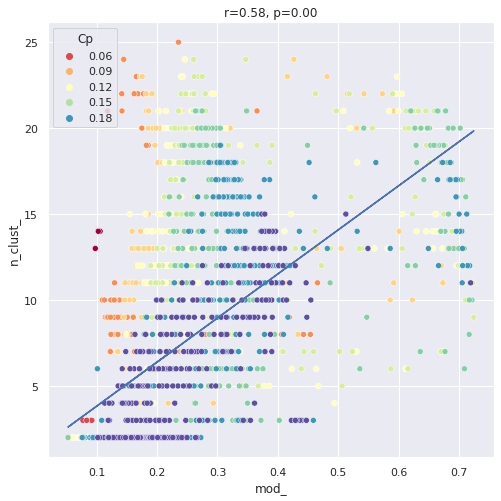

In [14]:
fig, ax = plt.subplots(1,1, figsize=(8, 8))
d = np.polyfit(dd.mod_, dd.n_clust_, 1)
f = np.poly1d(d)
_ = sns.scatterplot(data=dd, x='mod_', y='n_clust_', palette='Spectral', hue='Cp', ax=ax)
ax.plot(dd.mod_, f(dd.mod_))
r, p = pearsonr(dd.mod_, dd.n_clust_)
ax.set_title(f'r={r:.2f}, p={p:.2f}')

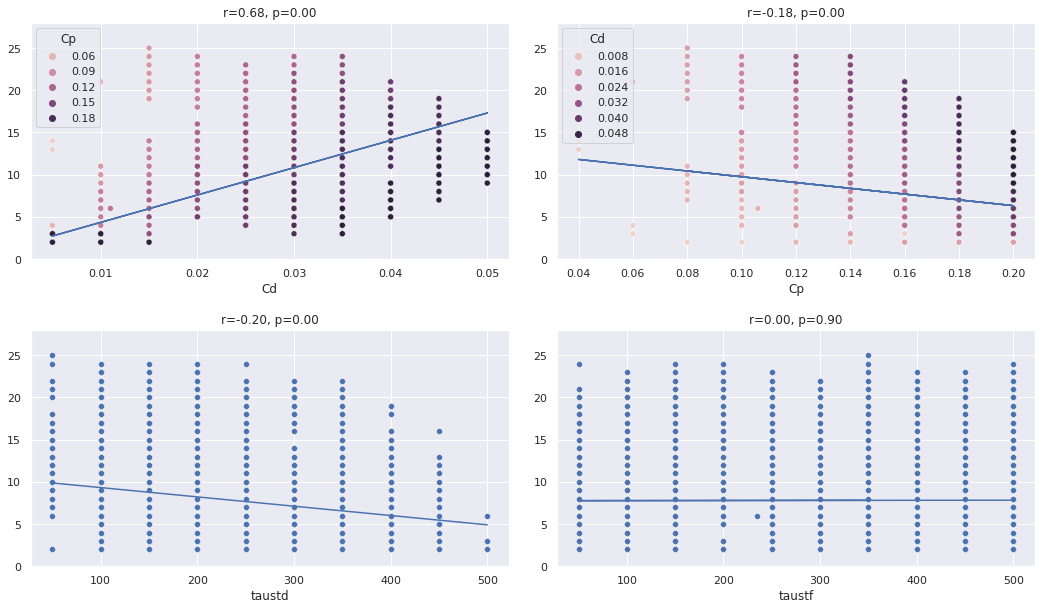

In [15]:
# inspect how some several network parametrs affect the number of clusters at equilibrium

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
param=[['Cd', 'Cp'], ['taustd', 'taustf']]
hue=[['Cp', 'Cd'], [None, None]]
for i in range(2):
    for j in range(2):
        d = np.polyfit(dd[param[i][j]], dd.n_clust_, 1)
        f = np.poly1d(d)
        ax[i,j].plot(dd[param[i][j]], f(dd[param[i][j]]))
        r, p = pearsonr(dd['n_clust_'], dd[param[i][j]])
        sns.scatterplot(data=dd, x=param[i][j], y='n_clust_', hue=hue[i][j], ax=ax[i,j])
        ax[i,j].set_title(f'r={r:.2f}, p={p:.2f}')
        ax[i,j].set_ylim(0, 28)
        ax[i,j].yaxis.label.set_visible(False)
fig.subplots_adjust(wspace=0.1, hspace=0.3)
plt.savefig('Dependence_nclust_params.png', dpi=300)

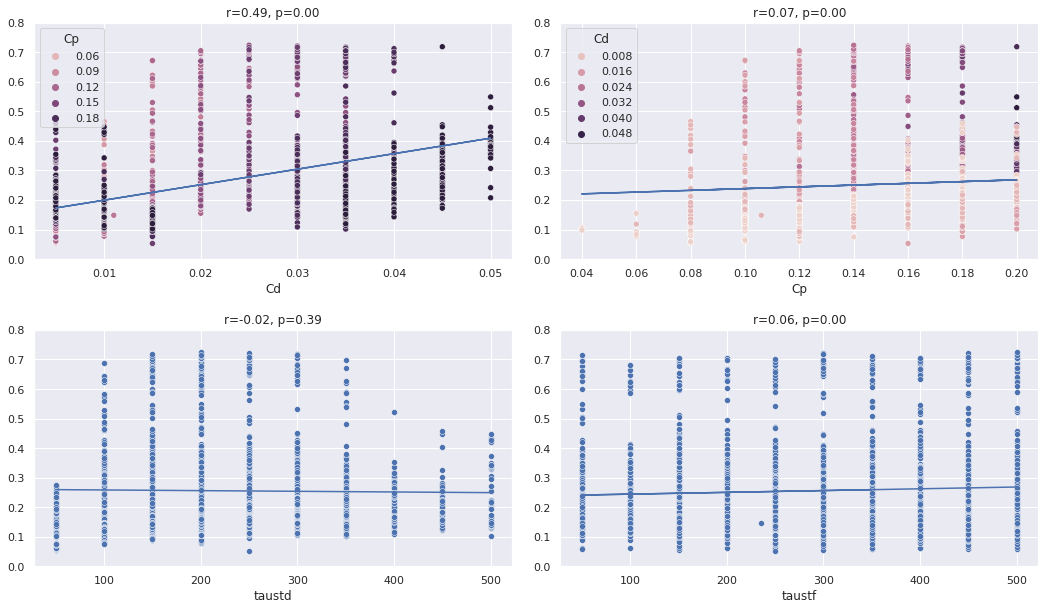

In [16]:
# inspect how some several network parametrs affect MODULARITY at equilibrium

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
param=[['Cd', 'Cp'], ['taustd', 'taustf']]
hue=[['Cp', 'Cd'], [None, None]]
for i in range(2):
    for j in range(2):
        d = np.polyfit(dd[param[i][j]], dd.mod_, 1)
        f = np.poly1d(d)
        ax[i,j].plot(dd[param[i][j]], f(dd[param[i][j]]))
        r, p = pearsonr(dd['mod_'], dd[param[i][j]])
        sns.scatterplot(data=dd, x=param[i][j], y='mod_', hue=hue[i][j], ax=ax[i,j])
        ax[i,j].set_title(f'r={r:.2f}, p={p:.2f}')
        ax[i,j].set_ylim(0, 0.8)
        ax[i,j].yaxis.label.set_visible(False)
fig.subplots_adjust(wspace=0.1, hspace=0.3)

In [14]:
max_t = []
for cellid in tmp.cell_id.unique():
    max_t.append((cellid, tmp[tmp.cell_id == cellid].t.max()))
grid = pd.DataFrame()
for i, tup in enumerate(max_t):
    grid = grid.append(tmp[(tmp.cell_id == tup[0]) & (tmp.t == tup[1])])
grid.reset_index(inplace=True, drop=True)
grid['cell_id'] = grid.cell_id.apply(int)
grid['dif'] = grid.apply(lambda x: np.abs(x.min_clust - x.max_clust), axis=1)
grid['Cp'] = grid.apply(lambda x: np.round(x.Cp, 3), axis=1)
grid['Cd'] = grid.apply(lambda x: np.round(x.Cd, 3), axis=1)

grid

,JOB_ID,TASK_ID,cell_id,t,mod,n_clust,min_clust,max_clust,U,Cp,Cd,tpp,tpd,taustf,taustd,dif
0,10514604.0,1.0,0,12025000.0,0.227640,6.0,371.0,480.0,0.7708,0.106,0.011,15.1549,120.4221,235.0004,100.0,109.0
1,10522689.0,1.0,691,12155000.0,0.024137,11.0,46.0,424.0,0.8000,0.020,0.035,15.1549,120.4221,500.0000,50.0,378.0
2,10523255.0,1.0,711,13995000.0,0.024669,12.0,35.0,453.0,0.8000,0.020,0.040,15.1549,120.4221,100.0000,50.0,418.0
3,10523451.0,1.0,721,13995000.0,0.024438,11.0,58.0,387.0,0.8000,0.020,0.040,15.1549,120.4221,150.0000,50.0,329.0
4,10523662.0,1.0,731,13995000.0,0.024242,12.0,27.0,430.0,0.8000,0.020,0.040,15.1549,120.4221,200.0000,50.0,403.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,10556588.0,1.0,3172,470000.0,0.037363,27.0,1.0,416.0,0.8000,0.080,0.010,15.1549,120.4221,400.0000,100.0,415.0
293,10556709.0,1.0,3181,630000.0,0.121177,10.0,166.0,582.0,0.8000,0.080,0.010,15.1549,120.4221,450.0000,50.0,416.0
294,10556710.0,1.0,3182,620000.0,0.089147,7.0,91.0,1624.0,0.8000,0.080,0.010,15.1549,120.4221,450.0000,100.0,1533.0
295,10556720.0,1.0,3191,535000.0,0.104699,9.0,175.0,473.0,0.8000,0.080,0.010,15.1549,120.4221,500.0000,50.0,298.0


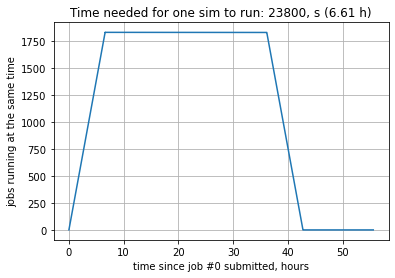

In [496]:
# precompile the share c++ module with O3, not Ofast if you run your grid on compute (on short use Ofast)
# set #SBATCH --time=0-6:45:0
# T_ms, saving time t in [5000, 400000, 700000, 1350000], and if mod > 0.035:
# sleep 13 (grid_search.sh)


cells_in_grid = 10000  # how many cells are in your grid
model_time_s = 1400     # how many seconds of model time we want to run
actual_time_to_run_one_second = 17      # estimated time to simulate on second, s
time_needed_for_one_simulation_s = model_time_s * actual_time_to_run_one_second
delay_between_jobs_s = 13  # how many seconds to wait before submitting the next job
max_time_s = 200000       # size of matrix (take enough, to fit the curve)
j = 0
x = np.zeros((cells_in_grid, max_time_s))
for i in range(cells_in_grid):
    x[i, j:j + time_needed_for_one_simulation_s] = 1
    j += delay_between_jobs_s
plt.plot(np.linspace(0, max_time_s/3600, max_time_s), x.sum(axis=0))
plt.ylabel('jobs running at the same time')
plt.xlabel('time since job #0 submitted, hours')
plt.title(f'Time needed for one sim to run: {time_needed_for_one_simulation_s}, s ({(time_needed_for_one_simulation_s/3600):.2f} h)')

plt.grid()

In [492]:
! scp readme.md roman-koshkin@deigo.oist.jp:/bucket/FukaiU/Roman/slurm/

readme.md                                     100%  128   142.2KB/s   00:00    


In [254]:
# see what's in the queue on deigo
! ssh deigo 'squeue'

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON) 
      10414668_[1]   compute JOBNAME1 roman-ko PD       0:00      1 (None) 
      10414669_[1]   compute JOBNAME1 roman-ko PD       0:00      1 (None) 
      10414671_[1]   compute JOBNAME1 roman-ko PD       0:00      1 (None) 
        10414168_1   compute JOBNAME1 roman-ko  R      34:05      1 deigo010922 
        10414169_1   compute JOBNAME1 roman-ko  R      34:05      1 deigo011203 
        10414170_1   compute JOBNAME1 roman-ko  R      34:05      1 deigo010901 
        10414166_1   compute JOBNAME1 roman-ko  R      34:39      1 deigo011222 
        10414162_1   compute JOBNAME1 roman-ko  R      34:43      1 deigo010906 
        10414163_1   compute JOBNAME1 roman-ko  R      34:43      1 deigo010922 
        10414164_1   compute JOBNAME1 roman-ko  R      34:43      1 deigo011222 
        10414156_1   compute JOBNAME1 roman-ko  R      35:10      1 deigo011203 
        10414157_1   compute JOBNAME1 

In [251]:
fnames = [i for i in os.listdir('/home/roman/Downloads/delete') if i.startswith(f'wts_')]

for fname in fnames:
    with open(f'/home/roman/Downloads/delete/{fname}', 'rb') as f:
        w = pickle.load(f)
        try:
            n = fname.split('_')[1]
            mod = df.iloc[int(n)]['mod']
            n_clust = df.iloc[int(n)]['n_clust']
            print(n)
        except:
            n = fname.split('_')[1].split('.')[0]
            mod = df.iloc[int(n)]['mod']
            n_clust = df.iloc[int(n)]['n_clust']
            print(n)
        _ = plt.imshow(w, vmin=0.1, vmax=0.6)
        _ = plt.colorbar()
        plt.title(f'mod: {mod:.2f} n_clust:{n_clust}')
        _ = plt.savefig(f'/home/roman/Downloads/delete/{fname}.png')
        
        _ = plt.clf()

7351
7943
7129
7304
7080
7371
7139
7072
7116
7064
7004
7413
7062
7362
7075
7356
7017
7225
7070
7025
7613
7088
7403
7451
7059
7453
7018
7085
7443
7301
7332
7096
7236
7033
7226
7372
7314
7066
7050
7238
7612
7228
7139
7057
7448
7118
7114
7003
7077
7121
7919
7126
7237
7060
7412
7047
7037
7112
7086
7102
7364
7608
7590
7117
7107
7315
7357
7052
7008
7452
7302
7016
7445
7130
7946
7015
7234
7128
7120
7138
7303
7108
7005
7611
7137
7446
7103
7069
7922
7353
7114
7393
7020
7607
7212
7101
7053
7593
7056
7414
7030
7029
7312
7055
7109
7592
7019
7040
7039
7104
7383
7406
7898
7344
7313
7078
7027
7010
7124
7023
7013
7300
7664
7401
7311
7224
7395
7233
7063
7415
7092
7099
7076
7897
7032
7036
7026
7416
7068
7034
7097
7049
7594
7664
7087
7079
7363
7116
7105
7125
7065
7136
7067
7038
7094
7899
7045
7454
7945
7117
7595
7352
7106
7227
7384
7403
7110
7119
7028
7140
7006
7235
7402
7447
7002
7407
7614
7947
7115
7007
7024
7048
7299
7417
7113
7897
7054
7022
6998
7944
7009
7089
7223
7354
7046
7355
7090
7115
7222
7058


<Figure size 432x288 with 0 Axes>